In [1]:
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        # Patch extaction and representation (layer 1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding=0)
        self.relu1 = nn.ReLU(inplace=True)

        # Non-linear mapping (layer 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.relu2 = nn.ReLU(inplace=True)

        # Reconstruction (layer 3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding=0)

        #initialize the filters with Gaussian distribution
        self._initialize_weights()


    def _initialize_weights(self):
        init.normal_(self.conv1.weight, mean=0, std=0.001)
        init.normal_(self.conv2.weight, mean=0, std=0.001)
        init.normal_(self.conv3.weight, mean=0, std=0.001)
        init.constant_(self.conv1.bias, 0)
        init.constant_(self.conv2.bias, 0)
        init.constant_(self.conv3.bias, 0)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x

In [4]:
model = SRCNN()  # Make sure to initialize the model first
checkpoint = torch.load("model_checkpoint_epoch_750.pth", map_location=torch.device('cpu'))  # Path to the saved model
model.load_state_dict(checkpoint)

/tmp/ipykernel_10998/4184902958.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_checkpoint_epoch_750.pth", map_location=torch.device('cpu'

<All keys matched successfully>

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
)

In [5]:
# load the images dataset from the disk
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        # lr_dir: path to the low resolution images
        # hr_dir: path to the high resolution images

        self.lr_dir = lr_dir
        self.hr_dir = hr_dir

        #list all the fieles in the directories
        self.lr_images = os.listdir(lr_dir)
        self.hr_images = os.listdir(hr_dir)

        #define the transformation to be applied to the images
        self.transform = transforms.ToTensor()
    
    def __len__(self):
        return len(self.lr_images)
    
    def __getitem__(self, index):
        lr_path = os.path.join(self.lr_dir, self.lr_images[index])
        hr_path = os.path.join(self.hr_dir, self.hr_images[index])

        lr_tensor = self.transform(Image.open(lr_path))
        hr_tensor = self.transform(Image.open(hr_path))

        return lr_tensor, hr_tensor
    
lr_dir = 'sub_images_lr'
hr_dir = 'sub_images_hr'

dataset = ImageDataset(lr_dir, hr_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [7]:
def calculate_psnr(original, reconstructed):
    # Compute Peak Signal-to-Noise Ratio (PSNR).
    mse = torch.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse))

In [9]:
def average_psnr(model, dataloader, crop_size=20):
    """
    Calculate the average PSNR over all samples in the dataloader.
    Args:
        model (nn.Module): The trained SRCNN model.
        dataloader (DataLoader): DataLoader for the training or test dataset.
        crop_size (int): The size of the central crop for PSNR calculation.
    Returns:
        float: Average PSNR value.
    """
    model.eval()
    total_psnr = 0.0
    total_images = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Crop the central 20x20 region
            _, _, h, w = outputs.size()
            start_h = (h - crop_size) // 2
            start_w = (w - crop_size) // 2
            outputs_crop = outputs[:, :, start_h:start_h+crop_size, start_w:start_w+crop_size]
            targets_crop = targets[:, :, start_h:start_h+crop_size, start_w:start_w+crop_size]

            # Calculate PSNR for each image
            for i in range(outputs_crop.size(0)):  # Iterate through batch
                psnr = calculate_psnr(outputs_crop[i], targets_crop[i])
                total_psnr += psnr
                total_images += 1

    average_psnr_value = total_psnr / total_images
    print(f"Average PSNR over {total_images} samples: {average_psnr_value:.2f} dB")
    return average_psnr_value

average_psnr(model, dataloader)

Average PSNR over 22227 samples: 52.32 dB


52.31501081276467

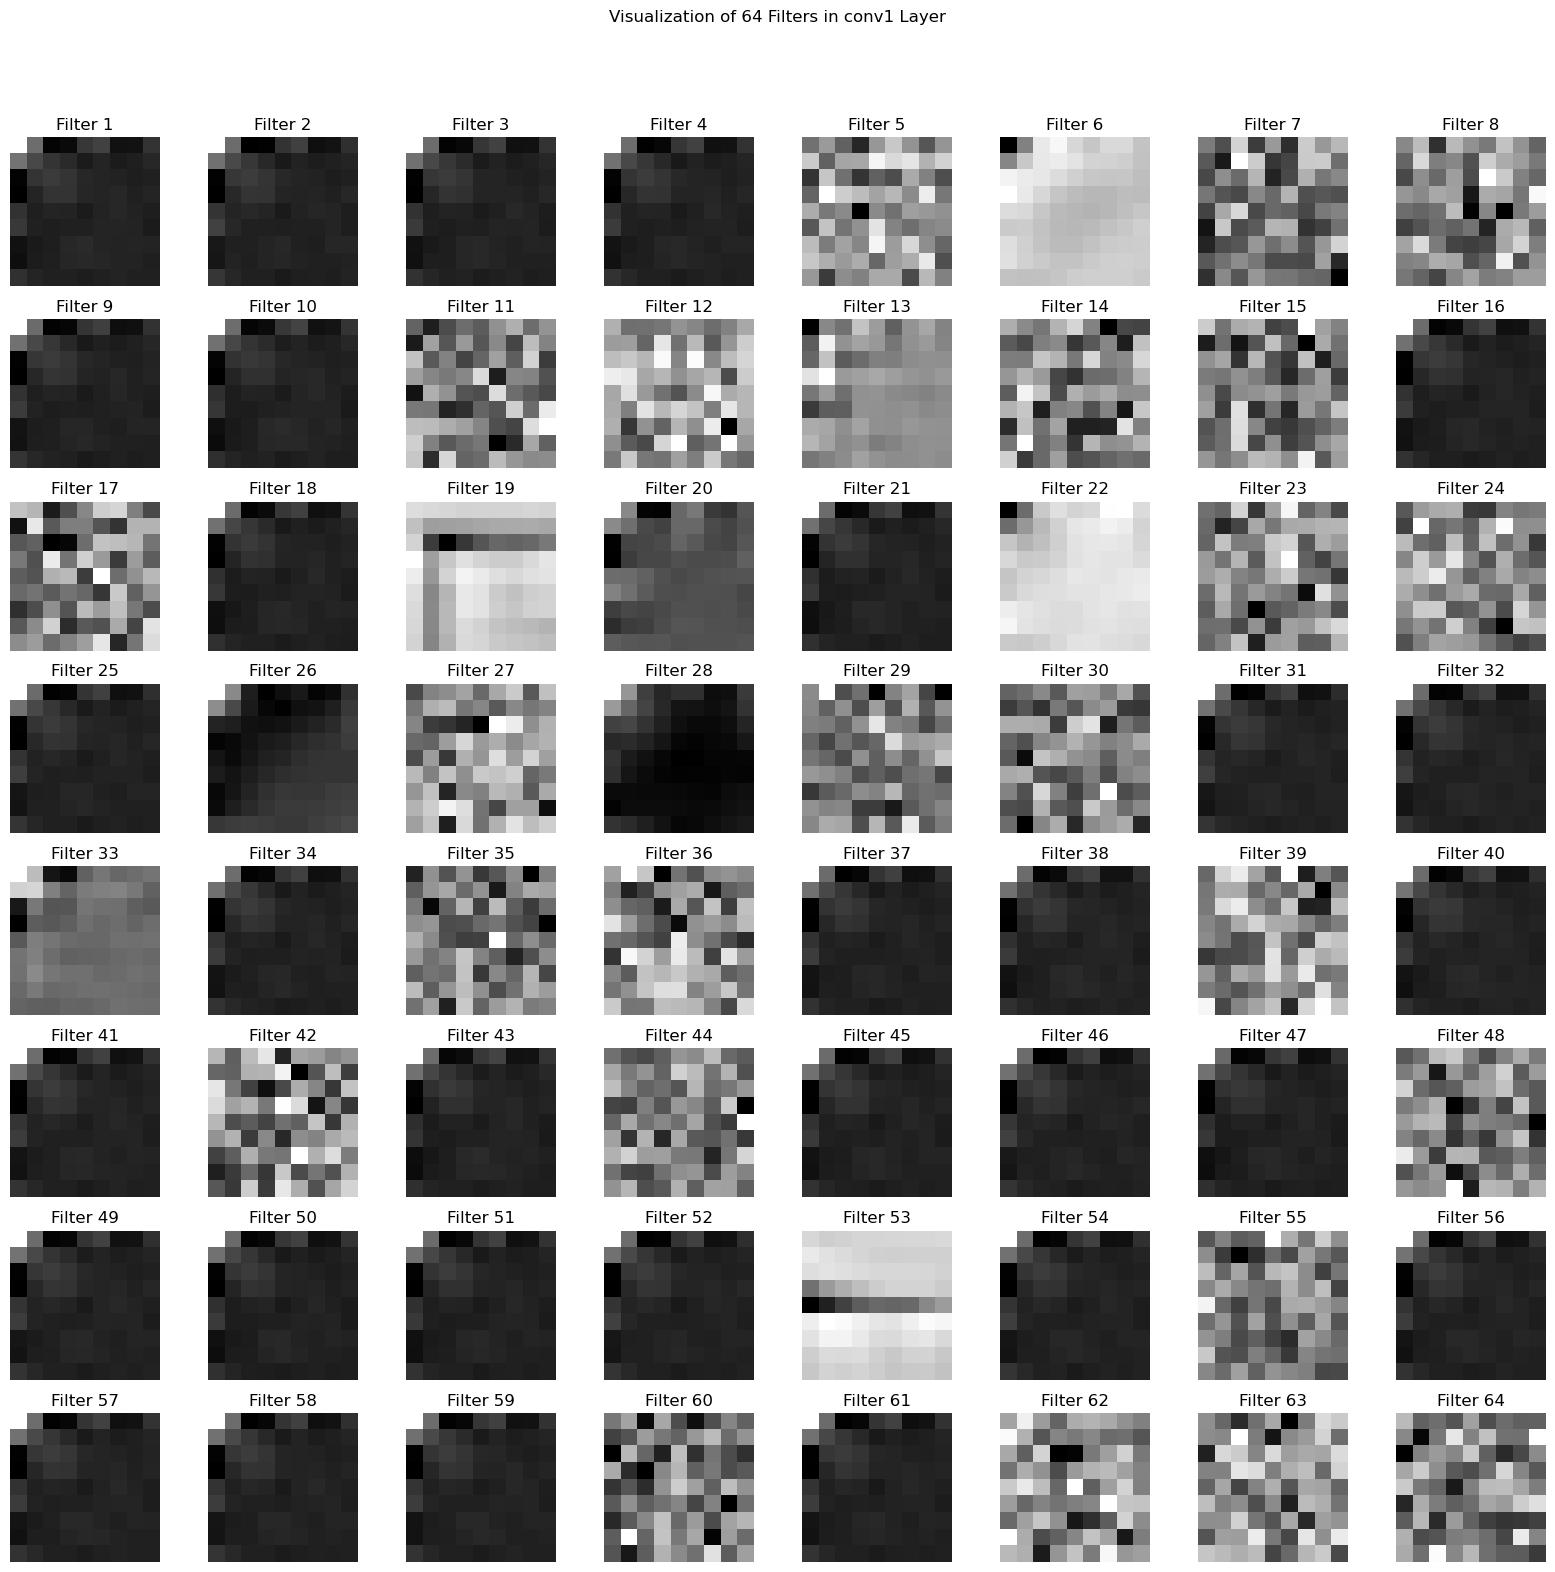

In [12]:
def plot_filters(model, layer_name='conv1', num_cols=8):
    """
    Plot the filters of the first convolutional layer in an 8x8 grid.
    Args:
        model (nn.Module): Trained SRCNN model.
        layer_name (str): Name of the convolutional layer to visualize filters from.
        num_cols (int): Number of columns in the grid. Default is 8.
    """
    # Get the first convolutional layer filters
    layer = getattr(model, layer_name)
    filters = layer.weight.data.cpu().numpy()  # Shape: (out_channels, in_channels, H, W)

    # Plot the filters (only the first channel since input is grayscale)
    num_filters = filters.shape[0]
    filter_size = filters.shape[2]

    num_rows = (num_filters + num_cols - 1) // num_cols  # Compute the number of rows

    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_filters):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(filters[i, 0, :, :], cmap='gray') 
        plt.axis('off')
        plt.title(f"Filter {i+1}")

    plt.suptitle("Visualization of 64 Filters in conv1 Layer")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_filters(model, layer_name='conv1', num_cols=8)


In [15]:
from PIL import ImageFilter

# for each image of Set5 dataset, make sub-images of size 32x32 and then find average PSNR for all the sub-images of a particular image.

input_dir = 'Set5'
output_dir_lr_set5 = 'sub_images_lr_set5'
output_dir_hr_set5 = 'sub_images_hr_set5'
sub_image_size = 32
stride = 14
scale = 2 #in this implementation we are taking the upscaling factor of 2 only
blur_radius = 1.0


count = 0 # just to keep track of the number of patches
for filename in os.listdir(input_dir):

    filepath = os.path.join(input_dir, filename)
    output_dir_hr = output_dir_hr_set5 + filename.split('.')[0]
    output_dir_lr = output_dir_lr_set5 + filename.split('.')[0]
    if not os.path.exists(output_dir_lr):
        os.makedirs(output_dir_lr)

    if not os.path.exists(output_dir_hr):
        os.makedirs(output_dir_hr)


    # First we will do it for greyscale images and then will extend it to color images
    # Convert to YCrCb
    img = Image.open(filepath).convert('YCbCr')
    img = img.split()[0] # get the Y channel

    h, w = img.size

    for i in range(0, h - sub_image_size + 1, stride):
        for j in range(0, w - sub_image_size + 1, stride):
            # get the high resolution sub-image
            hr_sub_image = img.crop((j, i, j + sub_image_size, i + sub_image_size))

            #add gaussian noise to the patch
            hr_patch_image = hr_sub_image.filter(ImageFilter.GaussianBlur(blur_radius))

            # Downsample and upsample the patch 
            # subsample the image by scale
            lr_patch_image = hr_patch_image.resize((sub_image_size//scale, sub_image_size//scale), Image.BICUBIC)
            # upsample the image by scale
            lr_patch_image = lr_patch_image.resize((sub_image_size, sub_image_size), Image.BICUBIC)

            # Save the sub-images
            lr_patch_image.save(os.path.join(output_dir_lr, filename.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'))
            hr_patch_image.save(os.path.join(output_dir_hr, filename.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'))

            count += 1

In [18]:
lr_dir = 'sub_images_lr_set5baby'
hr_dir = 'sub_images_hr_set5baby'

dataset_baby = ImageDataset(lr_dir, hr_dir)
dataloader_baby = DataLoader(dataset_baby, batch_size=32, shuffle=True)

average_psnr(model, dataloader_baby)

Average PSNR over 1225 samples: 48.00 dB


47.99503329817546

In [19]:
lr_dir = 'sub_images_lr_set5bird'
hr_dir = 'sub_images_hr_set5bird'

dataset_baby = ImageDataset(lr_dir, hr_dir)
dataloader_baby = DataLoader(dataset_baby, batch_size=32, shuffle=True)

average_psnr(model, dataloader_baby)

Average PSNR over 361 samples: 48.25 dB


48.25294474145155

In [20]:
lr_dir = 'sub_images_lr_set5butterfly'
hr_dir = 'sub_images_hr_set5butterfly'

dataset_baby = ImageDataset(lr_dir, hr_dir)
dataloader_baby = DataLoader(dataset_baby, batch_size=32, shuffle=True)

average_psnr(model, dataloader_baby)

Average PSNR over 289 samples: 41.97 dB


41.9738344830234

In [21]:
lr_dir = 'sub_images_lr_set5head'
hr_dir = 'sub_images_hr_set5head'

dataset_baby = ImageDataset(lr_dir, hr_dir)
dataloader_baby = DataLoader(dataset_baby, batch_size=32, shuffle=True)

average_psnr(model, dataloader_baby)

Average PSNR over 324 samples: 48.39 dB


48.39254523687258

In [22]:
lr_dir = 'sub_images_lr_set5woman'
hr_dir = 'sub_images_hr_set5woman'

dataset_baby = ImageDataset(lr_dir, hr_dir)
dataloader_baby = DataLoader(dataset_baby, batch_size=32, shuffle=True)

average_psnr(model, dataloader_baby)

Average PSNR over 345 samples: 57.00 dB


57.002917248027664